#Прогин балки.

Геометрично нелінійний випадок

$\cfrac{d^2w}{dx^2}=\cfrac{M(x)}{EI} \left( 1+ \left(\cfrac{dw}{dx} \right)^2 \right)^{3/2}$

Лінійний випадок

$\cfrac{d^2w}{dx^2}=\cfrac{M(x)}{EI}$



##Защемлення


![picture](https://drive.google.com/uc?id=19vWQY0lymRwPEDH2wq3UlpscL9E-5VVI)


Граничні умови

$w(0)=0,$
$\cfrac{dw}{dx}(0)=0$

Розв'язок

$w=\cfrac{-P}{EI}x^2 \left( \cfrac{L}{2} - \cfrac{x}{6} \right)$



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import math


In [ ]:
math.pi

3.141592653589793

In [ ]:
L = 1.0
q = 30
# G = 2.77 * 10**4
# nu = 0.3
# E = 2*G*(1+nu)
E = 70*10**9
h = 0.01
I = math.pi * (h**4)/64
print(I)

4.908738521234052e-10


In [ ]:
def w(x, q, E, I, L):
    return q/(E*I)*x**2*(L/2 - x/6)

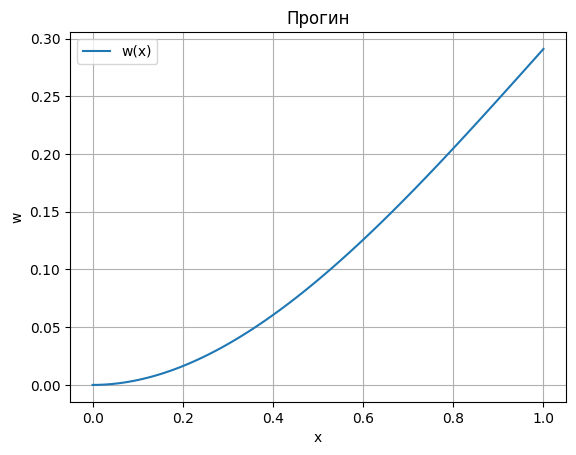

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Генерація значень x в діапазоні від -10 до 10
x_values = np.linspace(0, L, 100)

# Обчислення значень y за допомогою функції
y_values = w(x_values, q, E, I, L)

# Побудова графіка
plt.plot(x_values, y_values, label='w(x)')
plt.title('Прогин')
plt.xlabel('x')
plt.ylabel('w')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
w(L, q, E, I, L)

0.29102618165375155

#Розв'язок за допомогою PINN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        # def init_weights(m):
        #     if isinstance(m, nn.Linear):
        #         nn.init.xavier_uniform(m.weight)
        #         m.bias.data.fill_(0.02)
        self.net = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh(),
            # nn.Linear(64,64),
            # nn.Tanh(),
            # nn.Linear(64,64),
            # nn.ReLU(),
            nn.Linear(64,1),
            # nn.ReLU()
        )

        # self.apply(init_weights)
        self.double()
    def forward(self,x):
        return self.net(x)

In [ ]:
# x = torch.rand(10, 1, requires_grad = True)
# x

In [ ]:
# x = (0 - 2)*torch.rand(10, 1, requires_grad = True) + 2 + 0.000000000001
# x

In [ ]:
def initial_condition():
    return torch.tensor([0.0])

def boundary_condition():
    return torch.tensor([0.0])

In [ ]:
def generate_training_data(num_points, L):
    # x = torch.rand(num_points, 1, requires_grad = True)

    # x_rand = (0 - R)*torch.rand(int(num_points), 1, requires_grad = True) + R + 0.0001

    # x_vals = torch.linspace(0+0.001, R-0.001, num_points, requires_grad = True)
    # x_vals = x_vals + x_rand.flatten()
    # x = torch.stack([x_vals.double()], dim=1)


    # x = (0 - L)*torch.rand(int(num_points), 1, requires_grad = True) + L

    x_vals = torch.linspace(0, L, num_points, requires_grad = True)
    x = torch.stack([x_vals.double()], dim=1)


    return x

In [ ]:
tmp = torch.tensor([0.4])
tmp.view(-1,1)

tensor([[0.4000]])

In [ ]:
def generate_boundary_points(b_point):
    x_boundary = torch.tensor([b_point],  requires_grad = True)


    return x_boundary.view(-1,1)


def generate_boundary_training_data(b_point):
    x_boundary = generate_boundary_points(b_point)


    return x_boundary

$\cfrac{d^2w}{dx^2}=\cfrac{M(x)}{EI} \left( 1+ \left(\cfrac{dw}{dx} \right)^2 \right)^{3/2}$


In [ ]:
def pde(x, model):

    x = x.double()

    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    input_data = x

    # print('*********************************************************')
    # print(input_data.size())
    # print(input_data.dtype)

    u = model(input_data)
    u_x = torch.autograd.grad(u, x, grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs= torch.ones_like(u_x), create_graph= True, retain_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, grad_outputs= torch.ones_like(u_xx), create_graph= True, retain_graph=True)[0]
    u_xxxx = torch.autograd.grad(u_xxx, x, grad_outputs= torch.ones_like(u_xxx), create_graph= True, retain_graph=True)[0]
    # print('*********************************************************')
    # print(u_x.size())
    # print(u_x.dtype)
    # print('*********************************************************')
    # print(u.size())
    # print(u.dtype)
    # print('*********************************************************')
    # print(x.size())
    # print(x.dtype)

    eq_residual = u_xx
    return eq_residual

In [ ]:
def train_PINN(model, num_iterations, num_points, q, L, E, I):


    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # optimizer = optim.SGD(model.parameters(), lr=1e-3)
    # optimizer = optim.LBFGS(model.parameters())
    # breakpoint()
    # x = generate_training_data(num_points, R)
    for  iteration in range(num_iterations):
        optimizer.zero_grad()

        # breakpoint()

        x = generate_training_data(num_points, L)

        # print('generate_training_data')
        # print(x)
        # breakpoint()


        x_b = generate_boundary_training_data(L)


        # print('generate_boundary_training_data')
        # print(x_b)
        # breakpoint()

        x_initial = torch.tensor([0.0],  requires_grad = True)
        x_initial = x_initial.view(-1,1)
        x_initial = x_initial.double()

        # print('x_initial')
        # print(x_initial)
        # breakpoint()

        u_initial_x = initial_condition()
        u_initial_x = u_initial_x.double()

        # print('u_initial_x')
        # print(u_initial_x)
        # breakpoint()


        u_boundary_x = boundary_condition()

        # print('boundary_condition')
        # print(u_boundary_x)
        # breakpoint()

        residual = pde(x, model)

        # print('residual')
        # print(residual)
        # breakpoint()

        u_boundary_x = u_boundary_x.double()
        x_b = x_b.double()

        ub = model(x_b)
        ui = model(x_initial)

        ub_x = torch.autograd.grad(ub, x_b, grad_outputs= torch.ones_like(ub), create_graph= True, retain_graph=True)[0]
        ub_xx = torch.autograd.grad(ub_x, x_b, grad_outputs= torch.ones_like(ub_x), create_graph= True, retain_graph=True)[0]
        ub_xxx = torch.autograd.grad(ub_xx, x_b, grad_outputs= torch.ones_like(ub_xx), create_graph= True, retain_graph=True)[0]

        ui_x = torch.autograd.grad(ui, x_initial, grad_outputs= torch.ones_like(ui), create_graph= True, retain_graph=True)[0]


        u = model(x)
        u_x = torch.autograd.grad(u, x, grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]





        # print('ub_x')
        # print(ub_x)

        # print('ui_x')
        # print(ui_x)

        # print('ui')
        # print(ui)

        # print('ub')
        # print(ub)

        # breakpoint()

        p = q*L-q*x

        # print(p.dtype)

        # residual_r = torch.tensor([(p)/(E*I)]).double()*(1+(u_x)**2)**(3/2)
        residual_r = (p)/(E*I)*(1+(u_x)**2)**(3/2)

        residual_r = residual_r.double()

        # print('residual_r')
        # print(residual_r)
        # breakpoint()

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, torch.zeros_like(residual))

        # loss =  nn.MSELoss()(u_boundary_x, ub) + \
        #         nn.MSELoss()(u_boundary_x, ub_x) + \
        #         nn.MSELoss()(u_boundary_x, (x_b)*ub_xx + nu*ub_x) + \
        #         nn.MSELoss()(u_initial_x, ui_x) + \
        #         nn.MSELoss()(residual, residual_r)

        loss =  nn.MSELoss()(u_boundary_x, ub_xx) + \
                nn.MSELoss()(u_boundary_x, ub_xxx) + \
                nn.MSELoss()(u_initial_x, ui_x) + \
                nn.MSELoss()(u_initial_x, ui) + \
                nn.MSELoss()(residual, residual_r)



        # l1_regularization, l2_regularization = torch.tensor(0.0), torch.tensor(0.0)
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, 1)**2
        #     l2_regularization += torch.norm(param, 2)**2

        # loss = loss + l1_regularization + l2_regularization

        # print('loss')
        # print(loss)
        # breakpoint()

        loss.backward()

        # breakpoint()

        optimizer.step()

        # breakpoint()

        if iteration % 100 == 0:
            print("itration", iteration, "loss", loss )

In [ ]:
model = PINN()
num_iterations = 20000
num_points = 100
train_PINN(model, num_iterations, num_points, q, L, E, I)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning:

Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



itration 0 loss tensor(0.2339, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 100 loss tensor(0.1678, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 200 loss tensor(0.1517, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 300 loss tensor(0.1356, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 400 loss tensor(0.1199, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 500 loss tensor(0.1048, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 600 loss tensor(0.0905, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 700 loss tensor(0.0773, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 800 loss tensor(0.0652, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 900 loss tensor(0.0546, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1000 loss tensor(0.0455, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1100 loss tensor(0.0380, dtype=torch.float64, grad_fn=<AddBackward0>)
itration 1200 loss tensor(0.0321, dtype=torch.float64, grad_fn=<

In [ ]:
with torch.no_grad():
    x_vals = torch.linspace(0, L-0.00001, 50)


    input_data = torch.stack([x_vals.double()], dim=1)
    solution = model(input_data)
    sol = torch.stack([x_vals, solution.flatten()], dim=1)

    print(sol)



tensor([[ 0.0000e+00, -2.7752e-06],
        [ 2.0408e-02,  1.5354e-04],
        [ 4.0816e-02,  6.6129e-04],
        [ 6.1224e-02,  1.5172e-03],
        [ 8.1632e-02,  2.7172e-03],
        [ 1.0204e-01,  4.2567e-03],
        [ 1.2245e-01,  6.1303e-03],
        [ 1.4286e-01,  8.3322e-03],
        [ 1.6326e-01,  1.0856e-02],
        [ 1.8367e-01,  1.3696e-02],
        [ 2.0408e-01,  1.6844e-02],
        [ 2.2449e-01,  2.0294e-02],
        [ 2.4490e-01,  2.4039e-02],
        [ 2.6530e-01,  2.8072e-02],
        [ 2.8571e-01,  3.2385e-02],
        [ 3.0612e-01,  3.6973e-02],
        [ 3.2653e-01,  4.1829e-02],
        [ 3.4694e-01,  4.6946e-02],
        [ 3.6734e-01,  5.2319e-02],
        [ 3.8775e-01,  5.7942e-02],
        [ 4.0816e-01,  6.3811e-02],
        [ 4.2857e-01,  6.9918e-02],
        [ 4.4898e-01,  7.6261e-02],
        [ 4.6938e-01,  8.2834e-02],
        [ 4.8979e-01,  8.9631e-02],
        [ 5.1020e-01,  9.6649e-02],
        [ 5.3061e-01,  1.0388e-01],
        [ 5.5101e-01,  1.113

In [ ]:
sol_np = sol.numpy()
np.shape(sol_np)
points = sol_np[:, 0]
points

array([0.        , 0.02040796, 0.04081592, 0.06122388, 0.08163184,
       0.1020398 , 0.12244776, 0.14285572, 0.16326368, 0.18367164,
       0.2040796 , 0.22448756, 0.24489552, 0.26530349, 0.28571144,
       0.30611938, 0.32652736, 0.34693533, 0.36734328, 0.38775122,
       0.4081592 , 0.42856717, 0.44897512, 0.46938306, 0.48979104,
       0.51019895, 0.53060693, 0.5510149 , 0.57142282, 0.59183079,
       0.61223876, 0.63264668, 0.65305465, 0.67346263, 0.6938706 ,
       0.71427858, 0.73468649, 0.75509447, 0.77550244, 0.79591036,
       0.81631833, 0.83672631, 0.85713428, 0.87754226, 0.89795017,
       0.91835815, 0.93876612, 0.95917404, 0.97958201, 0.99998999])

In [ ]:
pred_y = []
true_y = []
pred_y = sol_np[:, 1]
for x in points:
    true_y.append(w(x, q, E, I, L))

print(true_y)

[0.0, 0.0001805751781791659, 0.000717353497217543, 0.0016029141338664498, 0.0028298362648772053, 0.004390699067001129, 0.006278081716989538, 0.008484563391593751, 0.01100272326756509, 0.01382514052165487, 0.016944394330614412, 0.020353063871195037, 0.02404372832014806, 0.028008969847935942, 0.03224135865017658, 0.03673347951174905, 0.04147791873471051, 0.04646724910742206, 0.051694041987760425, 0.05715088367778325, 0.06283036182333687, 0.06872504778229846, 0.07482751165545036, 0.08113034108863934, 0.0876261248981115, 0.0943074134071548, 0.10116682482191242, 0.10819691905640175, 0.11539025403061941, 0.12273945094173898, 0.1302370681757521, 0.13787566238471374, 0.14564785736670188, 0.15354621017474546, 0.16156329996934052, 0.16969170591098306, 0.1779239829719647, 0.18625275841825872, 0.19467058751476204, 0.20317002448599278, 0.2117436981584923, 0.22038416298436303, 0.22908399812410113, 0.2378357827382025, 0.24663207023836906, 0.255465491185143, 0.26432859910944206, 0.2732139471953628, 0.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot

def plot_feature(true_y, pred_y, points):

    fig_prices = go.Figure()
    fig_prices.add_trace(go.Scatter(x=points, y=true_y,
                        # fill= 'tonexty',
                        mode='lines',
                        # line_color='indigo',
                        name="Лінійний розв'язок"))
    fig_prices.add_trace(go.Scatter(
                        x=points,
                        y=pred_y,
                        # fill='tonexty', # fill area between trace0 and trace1
                        mode='lines',
                        # line_color='red',
                        name="Нелінійний розв'язок"))


    fig_prices.update_layout(yaxis_title="Значення функції")
    fig_prices.update_layout(
    xaxis=dict(
        title='Точки колокації',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі X
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів-
    ),
    yaxis=dict(
        title='Значення функції',
        title_font=dict(size=20),  # Збільшення розміру шрифту підпису осі Y
        tickfont=dict(size=16),    # Збільшення розміру шрифту тікерів
    ),
    legend=dict(
        font=dict(size=18)          # Збільшення розміру шрифту легенди
    )
)
    fig_prices.show()

    return 0

In [ ]:
plot_feature(true_y, pred_y, points)

0

In [ ]:
w(L, q, E, I, L)

0.29102618165375155

In [ ]:
import pandas as pd
import numpy as np

# Об'єднання масивів в DataFrame та назви стовпців
df = pd.DataFrame({'True': true_y, 'Pred': np.round(pred_y, 6)})

# Вивід DataFrame
print(df)

        True      Pred
0   0.000000 -0.000003
1   0.000181  0.000154
2   0.000717  0.000661
3   0.001603  0.001517
4   0.002830  0.002717
5   0.004391  0.004257
6   0.006278  0.006130
7   0.008485  0.008332
8   0.011003  0.010856
9   0.013825  0.013696
10  0.016944  0.016844
11  0.020353  0.020294
12  0.024044  0.024039
13  0.028009  0.028072
14  0.032241  0.032385
15  0.036733  0.036973
16  0.041478  0.041829
17  0.046467  0.046946
18  0.051694  0.052319
19  0.057151  0.057942
20  0.062830  0.063811
21  0.068725  0.069918
22  0.074828  0.076261
23  0.081130  0.082834
24  0.087626  0.089631
25  0.094307  0.096649
26  0.101167  0.103882
27  0.108197  0.111325
28  0.115390  0.118972
29  0.122739  0.126816
30  0.130237  0.134851
31  0.137876  0.143070
32  0.145648  0.151464
33  0.153546  0.160024
34  0.161563  0.168740
35  0.169692  0.177603
36  0.177924  0.186601
37  0.186253  0.195722
38  0.194671  0.204954
39  0.203170  0.214286
40  0.211744  0.223703
41  0.220384  0.233195
42  0.22908

In [ ]:
df['True'].iloc[-1]

0.2910218103326829

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
y_true = [df['True'].iloc[-1]]
y_pred = [df['Pred'].iloc[-1]]
mean_absolute_percentage_error(y_true, y_pred)

0.06687192841344088